<a href="https://colab.research.google.com/github/TechTrailblazer22/Advanced-AI-Chatbot---SOC-2024/blob/main/Model%20Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import numpy as np

# Function to download Nifty-50 data
def download_nifty50_data():
    nifty50 = yf.download('^NSEI', start='2010-01-01', end='2023-01-01')
    return nifty50['Close']

# Download Nifty-50 dataset
nifty50 = download_nifty50_data()

[*********************100%%**********************]  1 of 1 completed


In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
# Function to scale the data
def scale_data(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1)).flatten()
    return scaled_data, scaler

# Function to inverse transform the scaled data
def inverse_scale_data(scaled_data, scaler):
    return scaler.inverse_transform(scaled_data.reshape(-1, 1)).flatten()

In [11]:
# Function to check stationarity and difference the data if needed
def check_stationarity(data, alpha=0.05):
    result = adfuller(data)
    if result[1] > alpha:
        return False
    return True

In [12]:
def make_stationary(data):
    d = 0
    while not check_stationarity(data):
        data = np.diff(data)
        d += 1
    return data, d

In [15]:
import pandas as pd

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 2550
Model:                     AutoReg(5)   Log Likelihood               -3114.910
Method:               Conditional MLE   S.D. of innovations              0.823
Date:                Fri, 05 Jul 2024   AIC                           6243.821
Time:                        12:35:58   BIC                           6284.714
Sample:                             5   HQIC                          6258.654
                                 2550                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0174      0.016     -1.063      0.288      -0.049       0.015
y.L1          -0.0060      0.020     -0.305      0.761      -0.045       0.033
y.L2           0.0320      0.020      1.620      0.1

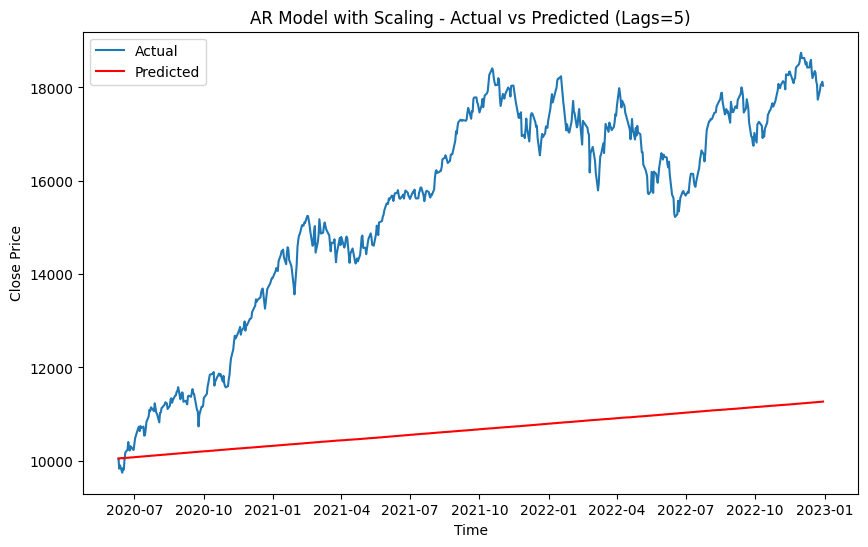

In [16]:
# Function to train AR model with scaling
def train_ar_model_with_scaling(data, lags):
    # Check stationarity and make data stationary
    data_stationary, d = make_stationary(data.values)

    # Convert stationary data to DataFrame
    data_stationary = pd.Series(data_stationary)

    # Scale the data
    scaled_data, scaler = scale_data(data_stationary)

    # Split the data into training and testing sets
    train_size = int(len(scaled_data) * 0.8)
    train, test = scaled_data[:train_size], scaled_data[train_size:]

    # Fit AR model
    model = AutoReg(train, lags=lags)
    model_fit = model.fit()

    # Print summary of the model
    print(model_fit.summary())

    # Make predictions
    start = len(train)
    end = len(train) + len(test) - 1
    predictions = model_fit.predict(start=start, end=end, dynamic=False)

    # Inverse transform predictions and test data
    predictions_inverse = inverse_scale_data(predictions, scaler)
    test_inverse = inverse_scale_data(test, scaler)

    # Restore differenced predictions and test data to original scale
    for i in range(d):
        predictions_inverse = np.cumsum(np.concatenate([[data.iloc[train_size - 1]], predictions_inverse]))
        test_inverse = np.cumsum(np.concatenate([[data.iloc[train_size - 1]], test_inverse]))

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(data.values[train_size:train_size + len(test_inverse)], test_inverse))
    print('Test RMSE: %.3f' % rmse)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(data.index[train_size:train_size + len(test_inverse)], test_inverse, label='Actual')
    plt.plot(data.index[train_size:train_size + len(predictions_inverse)], predictions_inverse, color='red', label='Predicted')
    plt.title(f'AR Model with Scaling - Actual vs Predicted (Lags={lags})')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

# Train AR model with specified lags
lags = 5  # Example: AR with 5 lags
train_ar_model_with_scaling(nifty50, lags)

In [21]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [23]:
# Check stationarity and make data stationary
nifty50_stationary, d = make_stationary(nifty50.values)

# Convert stationary data to DataFrame
nifty50_stationary = pd.Series(nifty50_stationary)


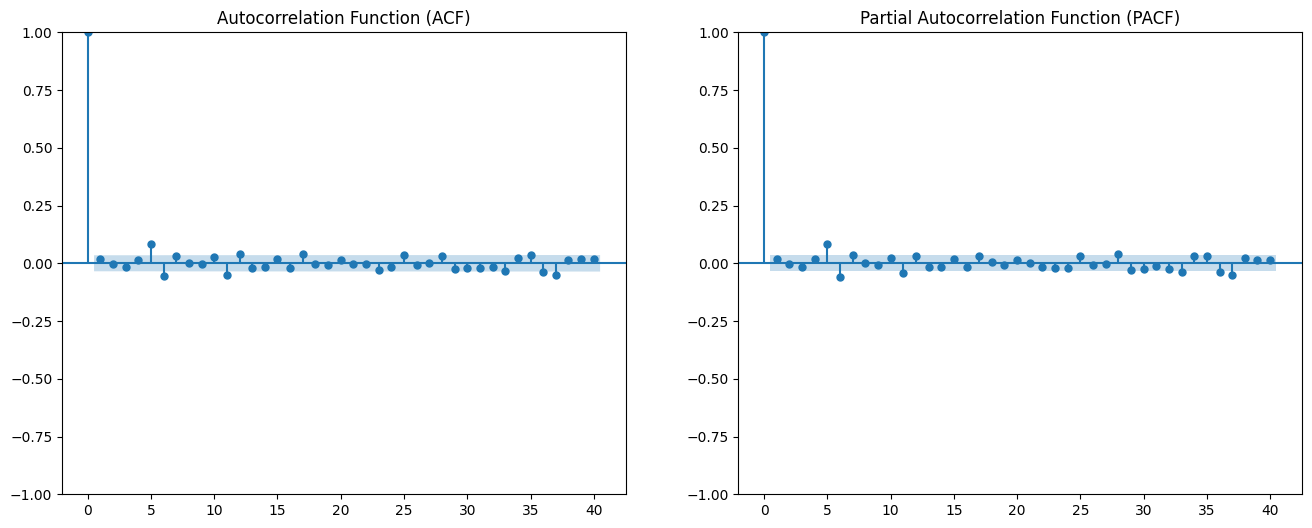

In [24]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ACF plot
plot_acf(nifty50_stationary, lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(nifty50_stationary, lags=40, ax=axes[1], method='ywm')
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2550
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -3082.474
Date:                Fri, 05 Jul 2024   AIC                           6186.947
Time:                        12:39:41   BIC                           6251.226
Sample:                             0   HQIC                          6210.260
                               - 2550                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6918      0.385     -4.400      0.000      -2.446      -0.938
ar.L2         -1.2563      0.761     -1.650      0.099      -2.748       0.236
ar.L3         -0.2375      0.635     -0.374      0.7

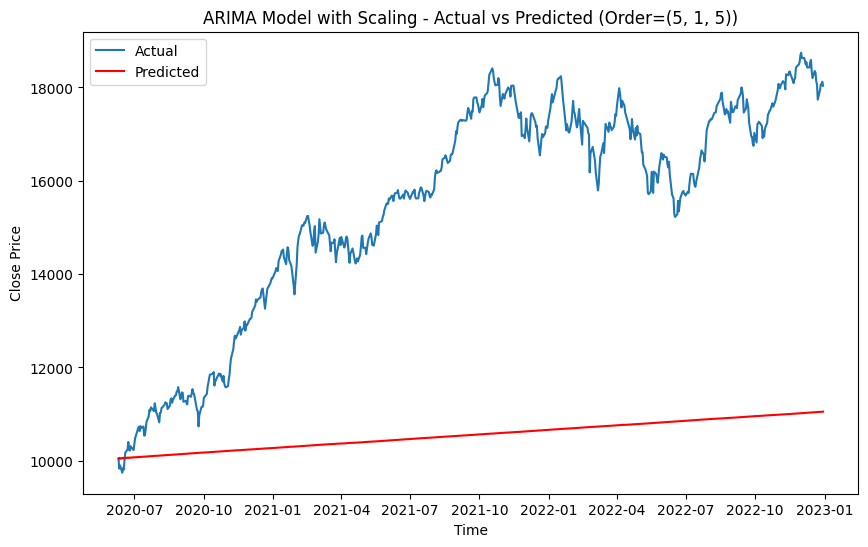

In [18]:
# Function to train ARIMA model with scaling
def train_arima_model_with_scaling(data, order):
    # Check stationarity and make data stationary
    data_stationary, d = make_stationary(data.values)

    # Convert stationary data to DataFrame
    data_stationary = pd.Series(data_stationary)

    # Scale the data
    scaled_data, scaler = scale_data(data_stationary)

    # Split the data into training and testing sets
    train_size = int(len(scaled_data) * 0.8)
    train, test = scaled_data[:train_size], scaled_data[train_size:]

    # Fit ARIMA model
    model = ARIMA(train, order=order)
    model_fit = model.fit()

    # Print summary of the model
    print(model_fit.summary())

    # Make predictions
    start = len(train)
    end = len(train) + len(test) - 1
    predictions = model_fit.predict(start=start, end=end, dynamic=False)

    # Inverse transform predictions and test data
    predictions_inverse = inverse_scale_data(predictions, scaler)
    test_inverse = inverse_scale_data(test, scaler)

    # Restore differenced predictions and test data to original scale
    for i in range(d):
        predictions_inverse = np.cumsum(np.concatenate([[data.iloc[train_size - 1]], predictions_inverse]))
        test_inverse = np.cumsum(np.concatenate([[data.iloc[train_size - 1]], test_inverse]))

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(data.values[train_size:train_size + len(test_inverse)], test_inverse))
    print('Test RMSE: %.3f' % rmse)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(data.index[train_size:train_size + len(test_inverse)], test_inverse, label='Actual')
    plt.plot(data.index[train_size:train_size + len(predictions_inverse)], predictions_inverse, color='red', label='Predicted')
    plt.title(f'ARIMA Model with Scaling - Actual vs Predicted (Order={order})')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

# Determine the order of the ARIMA model using ACF and PACF plots
order = (5, 1, 5)  # Example: Adjust this based on ACF and PACF plots
train_arima_model_with_scaling(nifty50, order)